# Exercise 7 and 8
by Lawrence Lechuga
02/24/21

## Import packages

In [5]:
%matplotlib inline
import random
from matplotlib import pyplot as plt
import os
import numpy as np
import skimage as sk
from skimage import io, filters, exposure, segmentation, img_as_float, data
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
import SimpleITK as sitk

### Create a SimpleITK based viewer
We are using the GetArrayViewFromImage() function from Simple ITK in order to convert an simpleITK based image into a numpy ndarray that we can view using matplotlib's pyplot.imshow.

***SimpleITK Image notes:***
1. We can get help on any of these modules using: >>> help('ModuleName').
2. SimpleITK imaging basics for those interested
    - http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/01_Image_Basics.html
    - http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/02_Pythonic_Image.html
 

In [6]:
def sitkshow(Img,title):
    NDA = sitk.GetArrayFromImage(Img)
    H = plt.imshow(NDA,cmap='gray')
    plt.title(title,fontsize = 18)
    plt.show()
    return H, NDA

### Set Path to image 
Set your path to the appropriate image in the cell below. 

Note: If this work is being launched from mybinder, then path should be set correctly from the start.

In [7]:
image_path = 'ITK_Images/'
img = 'BrainProtonDensitySlice6.png'
filename = os.path.join(image_path,img)

### Read in image and display
We will first read in the image using sitk.ReadImage() function.
I will load the "BrainProtonDensitySlice6.png" in as sitk based 32-bit float, or "sitk.sitkFloat32", then display using our custom function.

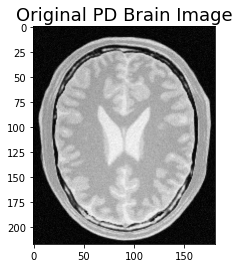

In [8]:
brain = sitk.ReadImage(filename,sitk.sitkFloat64)
I0 = sitkshow(brain,'Original PD Brain Image')

## 1. Preprocessing
In order to have a segmentation algorithm that performs optimally, we will need to process the images prior to segmentation. Lets start with smoothing the image.
### 1.1. Reduce Noise
We will reduce noise by using SimpleITK's "Curvature anisotropic diffusion image filter". The module SimpleITK.CurvatureAnisotropicDiffusionImageFilter() is a class that mimics (or is a proxy of) C++ itk::simple::CurvatureAnisoptropicDiffusionImageFilter class.

This python class object that I define below as CADIF, has many methods within it. If youre unfamiliar with classes and objects, think of it as a more efficiently way of grouping functionality and data together. If interested, https://docs.python.org/3/tutorial/classes.html has a great description of classes.

#### Action Required:
Have students set different attributes and try different values.

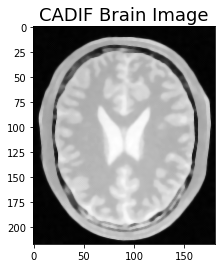

itk::simple::CurvatureAnisotropicDiffusionImageFilter
  TimeStep: 0.125
  ConductanceParameter: 9
  ConductanceScalingUpdateInterval: 1
  NumberOfIterations: 5
  Debug: 0
  NumberOfThreads: 4
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



In [9]:
CADIF = sitk.CurvatureAnisotropicDiffusionImageFilter()
CADIF.SetTimeStep(0.125)
CADIF.SetNumberOfIterations(5)
CADIF.SetConductanceParameter(9.0)
brain_filt = CADIF.Execute(brain)
I1 = sitkshow(brain_filt,'CADIF Brain Image')

print(CADIF)

### 1.2. Create a gradient image
Now that our image is filtered to remove some noise, we can determine our edges much more effectively. To find the edges of our image we will be using SimpleITK's "Gradient Magnitude Recursive Gaussian Image Filter".  The module SimpleITK.GradientMagnitudeRecursiveGaussianImageFilter() is a class that mimics (or is a proxy of) C++ itk::simple::GradientMagnitudeRecursiveGaussianImageFilter class. As you can see, very similar to the structure of the previous section.

#### Action Required:
Create something for the students to do here. Possibly have them show different values of sigma in a subplot?

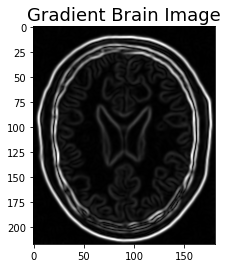

itk::simple::GradientMagnitudeRecursiveGaussianImageFilter
  Sigma: 1
  NormalizeAcrossScale: 0
  Debug: 0
  NumberOfThreads: 4
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



In [10]:
GF = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
GF.SetSigma(1.0)
brain_edge = GF.Execute(brain_filt)
I2 =sitkshow(brain_edge,'Gradient Brain Image')
print(GF)

### 1.3. Normalize magnitude
Lastly, we will normalize the magnitude using a sigmoid filter. This filter will take in each pixel and tranform its value based on the sigmoid function:
\begin{equation}
f(x) = (Max - Min)\cdot \frac{1}{1+ e^{-\frac{x-\beta}{\alpha}}}+ Min
\end{equation}
In the cell below, we can visualize how different parameters will affect the sigmoid response:

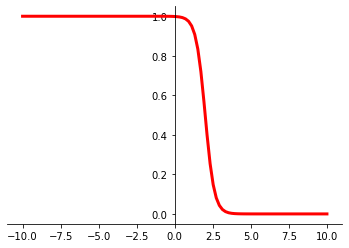

In [11]:
# small function to visualize the parameter effects
def sigmoid(MIN=0.0, MAX=1.0, ALPHA=-0.3, BETA=2.0):
    X = np.linspace(-10,10,100)
    Y = (MAX-MIN)*1/(1+np.exp(-(X-BETA)/ALPHA))+MIN
    return X,Y
x, y = sigmoid()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.plot(x,y, 'r',linewidth=3.0)
plt.show()

#### SigmoidImageFilter
Now we can input out gradient image into the sigmoid image filter that is controlled by SimpleITK's SigmoidImageFilter() class. This will normalize the gradient image for later segmentation.

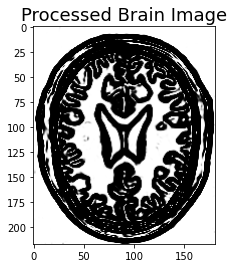

itk::simple::SigmoidImageFilter
  Alpha: -0.2
  Beta: 2
  OutputMaximum: 1
  OutputMinimum: 0
  Debug: 0
  NumberOfThreads: 4
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



In [12]:
#help(sitk.SigmoidImageFilter)
SIF = sitk.SigmoidImageFilter()
SIF.SetOutputMaximum(1.0)
SIF.SetOutputMinimum(0.0)
SIF.SetAlpha(-0.2)
SIF.SetBeta(2.0)
brain_processed = SIF.Execute(brain_edge)
brain_processed = sitk.Cast(brain_processed, sitk.sitkFloat64)
I3 =sitkshow(brain_processed,'Processed Brain Image')
print(SIF)

## 2.1 Segmentation
Now we can take our preprocessed image and apply our segmentation algorithm of choice.

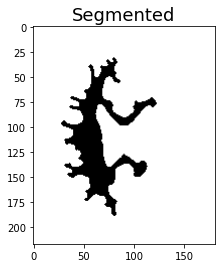

itk::simple::FastMarchingImageFilter
  TrialPoints: [ [ 56, 96, 0 ] ]
  NormalizationFactor: 1
  StoppingValue: 100
  Debug: 0
  NumberOfThreads: 4
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



In [16]:
stoppingValue = 100
seed_row = 56
seed_col = 96
seedValue =0
trialPoint = (seed_row, seed_col,seedValue)

FM = sitk.FastMarchingImageFilter()
FM.AddTrialPoint(trialPoint)
FM.SetStoppingValue(stoppingValue)
brainFM_seg = FM.Execute(brain_processed)

Ifs,segfm = sitkshow(brainFM_seg,'Segmented')

print(FM)

## 2.2 Morphological Geodesic Active Contours

<IPython.core.display.Javascript object>


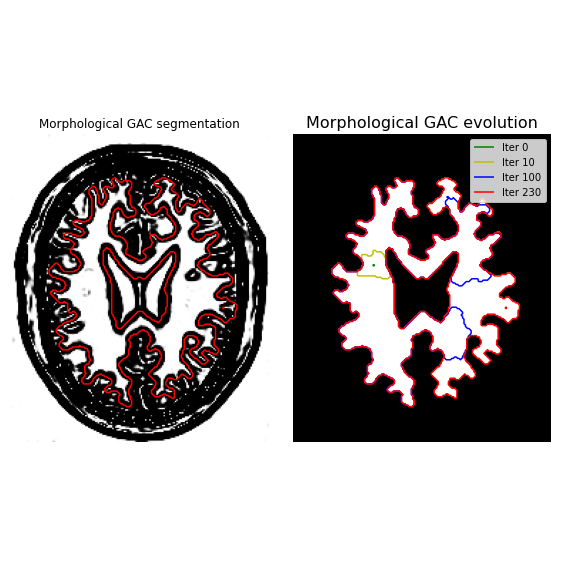

In [22]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """
    def _store(x):
        lst.append(np.copy(x))
    return _store

# Initial level set
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Morphological GAC
img = sitk.GetArrayFromImage(brain_processed)

# Initial level set
init_ls = np.zeros(img.shape, dtype=np.int8)
init_ls[92,56] = 1


# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)

ls = morphological_geodesic_active_contour(img, 350, init_level_set =init_ls,
                                           smoothing=1, balloon=1,
                                           threshold=0.69,
                                           iter_callback=callback)

ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iter 0")

contour = ax[1].contour(evolution[10], [0.5], colors='y')
contour.collections[0].set_label("Iter 10")

contour = ax[1].contour(evolution[100], [0.5], colors='b')
contour.collections[0].set_label("Iter 100")

contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iter 230")

ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=16)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


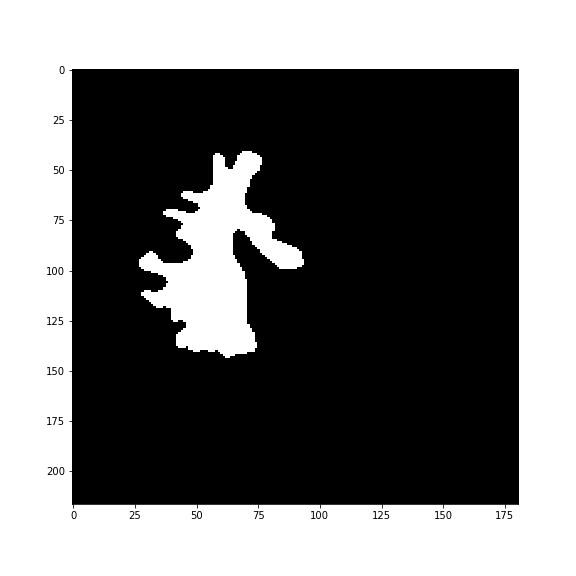

In [23]:
%matplotlib notebook
import matplotlib.animation as animation


fps = 25
nSeconds = 6

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = evolution[0]
im = plt.imshow(evolution[0], cmap ='gray',interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(evolution[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )


## EXTRA: Morphological Geodesic Active Contour Level Set

<IPython.core.display.Javascript object>


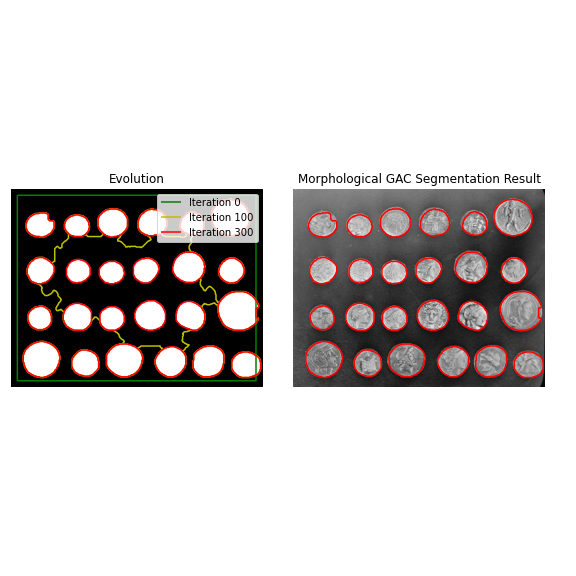

In [76]:
THRESH = 0.63 # threshold for what is considered a boundary.
# Create the figure structure
fig, axes = plt.subplots(1,2, figsize = (8,8))
ax = axes.flatten()

# load in the image and calculate its gradient image (inverse)
img = img_as_float(data.coins())
grad_img = inverse_gaussian_gradient(img)

# Initial level set
init_ls = np.zeros(img.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1 # this defines a box on the outter rim of the image

# Create empty list so we can store it with the the progress at each iteration 
evolution = []
callback = store_evolution_in(evolution)

# We can run our segmentation on the gradient image. This time we set the "baloon" to negative 1.
ls = morphological_geodesic_active_contour(grad_img, 300, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=THRESH,
                                           iter_callback=callback)



ax[0].imshow(ls, cmap="gray")
ax[0].set_axis_off()
contour = ax[0].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[0].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[0].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 300")
ax[0].legend(loc="upper right")
title = "Evolution"
ax[0].set_title(title, fontsize=12)

ax[1].imshow(img, cmap="gray")
ax[1].set_axis_off()
ax[1].contour(ls, [0.5], colors='r')
ax[1].set_title("Morphological GAC Segmentation Result", fontsize=12)



fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


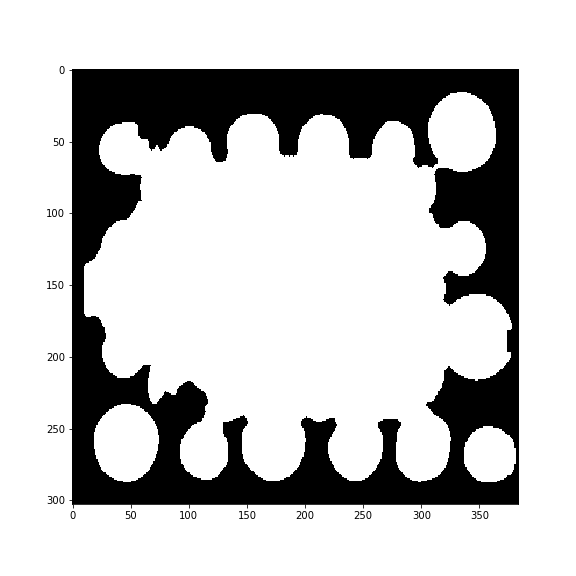

In [75]:
%matplotlib notebook
import matplotlib.animation as animation


fps = 25
nSeconds = 10

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = evolution[0]
im = plt.imshow(evolution[0], cmap ='gray',interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(evolution[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )